# Supervised metrics

The `sp` (supervised) module provides metrics to evaluate how well cell profiles in a spatial transcriptomics dataset agree with a reference single-cell RNA-seq (scRNA-seq) dataset with cell type annotations.

Unlike scRNA-seq, spatial transcriptomics measurements are affected by the local tissue context. Transcripts can be captured outside their cell of origin due to transcript diffusion, 3D overlap, or segmentation inaccuracies, leading to mixed or contaminated expression profiles. As a result, spatial cells may partially resemble their neighbors.

By comparing spatial expression profiles to a high-quality scRNA-seq reference, the supervised module aims to quantify this mismatch. Specifically, we use the scRNA-seq dataset as a clean reference, transfer cell type labels to the spatial data, and then compute metrics that measure:
- how well each spatial cell matches its expected cell type, and
- how much its expression resembles other (neighboring) cell types.

To follow along with this tutorial, you can download the data from [here](https://oc.embl.de/index.php/s/1JyN4Qvk4mw0T5J).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import spatialdata as sd
import spatialdata_plot  # noqa

import segtraq

/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/squidpy/gr/_utils.py:23: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  CAN_USE_SPARSE_ARRAY = Version(anndata.__vers

#### Transfer labels from scRNA-seq to spatial transcriptomics

We first load a spatial transcriptomics dataset (stored as a `SpatialData` object) and an annotated scRNA-seq reference dataset (stored as an `AnnData` object). For demonstration purposes, we subset the spatial dataset to a smaller region to reduce runtime.

Next, we initialize a `SegTraQ` object from the SpatialData. During initialization, the `validate_spatialdata()` method is automatically run to ensure that all required attributes (e.g. `images_key`, `tables_key`) are correctly specified.

We then transfer cell type labels from the scRNA-seq reference to the spatial dataset using `run_label_transfer()`. This method computes cell type–specific mean expression profiles in the reference and assigns each spatial cell to the cell type with the highest Pearson correlation to its expression profile.

Finally, we define a color scheme for visualizing the transferred cell type labels.

In [3]:
# Load spatial transcriptomics dataset
sdata_ws = sd.read_zarr("../../data/xenium.zarr/")

# Subset the dataset to a specific bounding box
bb_xmin = 800
bb_ymin = 1150
bb_w = 200
bb_h = 300
bb_xmax = bb_xmin + bb_w
bb_ymax = bb_ymin + bb_h

sdata = sdata_ws.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[bb_xmin, bb_ymin],
    max_coordinate=[bb_xmax, bb_ymax],
    target_coordinate_system="global",
)

# initialize SegTraQ object
st = segtraq.SegTraQ(sdata, images_key="image", tables_centroid_x_key="x_centroid", tables_centroid_y_key="y_centroid")

# Load scRNA-seq dataset
scRNAseq_data_path = Path("../../data/BC_scRNAseq_Janesick.h5ad")
adata_ref = ad.read_h5ad(scRNAseq_data_path)

# Define color palette for cell types
col_celltype = {
    "T": "#fb8072",
    "B": "#bc80bd",
    "macro": "#910290",
    "dendritic": "#fdb462",
    "mast": "#959059",
    "perivas": "#fed9a6",
    "endo": "#a6cee3",
    "myoepi": "#2782bb",
    "DCIS1": "#3c7761",
    "DCIS2": "#66a61e",
    "tumor": "#66c2a5",
    "stromal": "#d45943",
    "Unknown": "#808080",
}

/tmp/ipykernel_4091032/1120773328.py:2: UserWarning: SpatialData is not stored in the most current format. If you want to use Zarr v3, please write the store to a new location using `sdata.write()`.
  sdata_ws = sd.read_zarr("../../data/xenium.zarr/")
no parent found for <ome_zarr.reader.Label object at 0x7ffd41ea6750>: None
no parent found for <ome_zarr.reader.Label object at 0x7ffd41ea6810>: None
/home/lazic/.local/share/uv/python/cpython-3.11.13-linux-x86_64-gnu/lib/python3.11/functools.py:909: UserWarning: The object has `points` element. Depending on the number of points, querying MAY suffer from performance issues. Please consider filtering the object before calling this function by calling the `subset()` method of `SpatialData`.
  return dispatch(args[0].__class__)(*args, **kw)
/g/huber/users/lazic/src/SegTraQ/src/segtraq/SegTraQ.py:128: UserWarning: Missing 8 cell IDs in tables: ['icdokine-1', 'aphemnlm-1', 'icefbjdk-1', 'apnfcbpf-1', 'iceelejf-1']... These cells are present in

The transferred labels are stored in  
`sdata.tables[tables_key].obs["transferred_cell_type"]`.  
The column name can be changed via the `cell_type_key` argument.

By default, cells with **≤ 10 or ≥ 2000 transcripts** and **≤ 5 detected genes** are filtered out.  
These thresholds can be adjusted using `tx_min`, `tx_max`, `gn_min`, and `gn_max`.

Ensure that gene identifiers match between `adata_ref.var_names` and  
`sdata.tables[tables_key].var_names`. If they differ, specify the corresponding
identifier columns using `ref_ensemble_key` and `query_ensemble_key`.  
If these are left as `None` (default), `var_names` are used.

In [4]:
st.run_label_transfer(
    adata_ref,
    ref_cell_type="celltype_major",  # Reference cell type column
    ref_ensemble_key=None,
    query_ensemble_key=None,
)

/g/huber/users/lazic/src/SegTraQ/src/segtraq/utils.py:386: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ref_mean_df = counts_df.groupby("celltype").mean()
/g/huber/users/lazic/src/SegTraQ/src/segtraq/SegTraQ.py:346: RuntimeWarning: Spatialdata table appears to contain raw counts. Counts will be log1p-transformed before running label transfer.Raw counts will be stored in `adata_q.layers["raw"]`.
  result = _run_label_transfer(
/g/huber/users/lazic/src/SegTraQ/src/segtraq/utils.py:429: ImplicitModificationWarning: Setting element `.layers['raw']` of view, initializing view as actual.
  adata_q.layers["raw"] = adata_q.X


Next, cell shapes can be plotted and colored by cell type based on a defined color palette. Some cells lack a transferred cell-type label (due to filtering low-count cells before label transfer); for compatibility with `spatialdata-plot`, we replace missing values (`NaN`) with "Unknown" before plotting.

In [5]:
# Replace NaN with Unknown
s = st.sdata.tables["table"].obs["transferred_cell_type"]
if pd.api.types.is_categorical_dtype(s):
    s = s.cat.add_categories(["Unknown"])

st.sdata.tables["table"].obs["transferred_cell_type_plot"] = s.fillna("Unknown")

labels = st.sdata.tables["table"].obs["transferred_cell_type_plot"].unique().astype(str).tolist()
cols = [col_celltype[lab] for lab in labels]

/tmp/ipykernel_4091032/964490482.py:3: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(s):


/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata/_core/spatialdata.py:482: UserWarning: Converting `region_key: region` to categorical dtype.
  convert_region_column_to_categorical(table)
/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:872: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


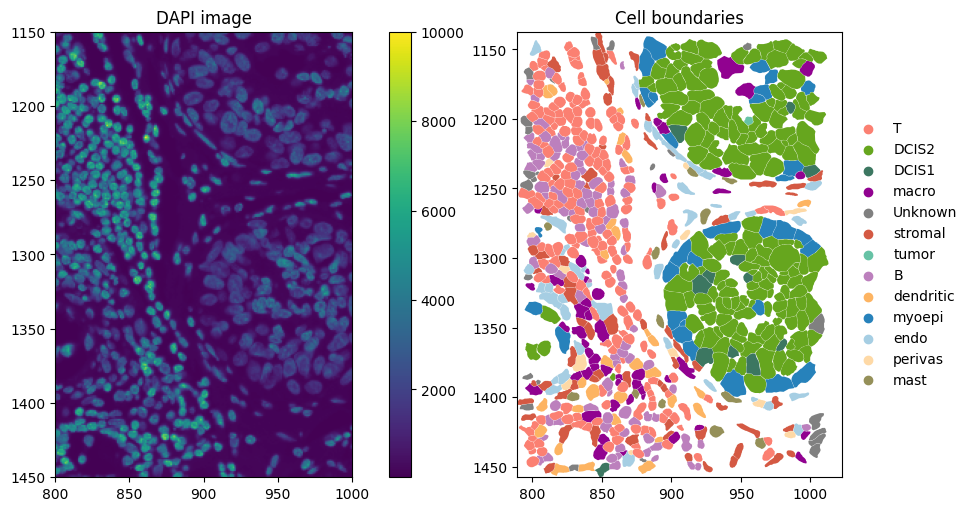

In [6]:
axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)[1].flatten()

# Dapi image
st.sdata.pl.render_images("image").pl.show(ax=axes[0], title="DAPI image", coordinate_systems="global")

# Add link between table and spatial element
st.sdata.tables["table"].obs["region"] = "cell_boundaries"
st.sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")

st.sdata.pl.render_shapes(
    "cell_boundaries",
    color="transferred_cell_type_plot",
    palette=cols,
    groups=labels,
    outline_color="white",  # outlines visible on black
    outline_width=0.5,
).pl.show(ax=axes[1], title="Cell boundaries", coordinate_systems="global")

Spatial data are normalized and log transformed for some of the metrics below. The raw counts will be saved in `sdata.tables[tables_key].layers["raw]`.

In [7]:
tables_key = "table"  # adjust as needed"

adata = st.sdata.tables[tables_key]
# Store raw counts
adata.layers["raw"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)


#### Computing cell type-specific markers

**Positive markers** are genes that are consistently upregulated in one cell type relative to other cell types. To avoid composition bias arising from unequal cell type abundances, we perform **pairwise comparisons between all cell types** in the reference dataset. Marker detection can be performed using either differential expression (`mode="de"`) or AUC-based scoring (`mode="auc"`).  

For each cell type, genes are selected by a voting scheme: a gene must be identified as upregulated in at least a fraction of pairwise contrasts (`vote_fraction_pos`, default = 0.5). To ensure that positive markers are representative of the cell type rather than driven by a small subset of cells, we additionally require that a gene is expressed (> 0) in at least `min_pos_frac` (default = 0.1) of cells of that type. To further increase specificity, we require that a positive marker is not shared by more than `t_pos × n_celltypes` cell types. This yields markers that are both upregulated and cell-type–specific, without bias from cell type composition in the reference data.

**Negative markers** are derived from the same pairwise contrasts but are defined as genes that are effectively off in a focal cell type while being upregulated elsewhere. For each ordered pair of cell types `(a, b)`, genes that are upregulated in `a` relative to `b` are considered negative-marker candidates for `b` if they are expressed (`> 0`) in at most `max_neg_frac` (default = 0.05) of cells of type b. To avoid ambiguous genes with inconsistent directionality, we further require that a negative marker of `b` is not identified as upregulated in `b` relative to any other cell type across all ordered contrasts.

When using `mode="auc"`, the minimum required AUC can be set via `auc_pos_thresh` (default = 0.9).  
When using `mode="de"`, the differential expression method can be selected via `method` (`"wilcoxon"`, `"t-test"`, or `"logreg"`), with thresholds defined by `logFC_pos_thresh` (default = 1.0) and `pval_adj_thresh` (default = 0.05).  

All computations can be parallelized by specifying the number of jobs via `n_jobs`.

Only genes common to the scRNA-seq and spatial transcriptomics dataset will be considered to reduce compute time.

In [8]:
# subsetting to commong genes
common_genes = adata.var_names[adata.var_names.isin(adata_ref.var_names)]
adata_ref = adata_ref[:, common_genes].copy()

In [ ]:
# get cell type-specific markers from the reference dataset
markers = segtraq.get_ref_markers(
    adata_ref,
    mode="de",
    vote_fraction_pos=0.5,
    min_pos_frac=0.1,
    max_neg_frac=0.05,
    ref_cell_type="celltype_major",
    n_jobs=16,
)

A list of positive and negative markers computed for each cell type is shown below. 

In [10]:
for cell_type, sign in markers.items():
    pos = sign["positive"]
    neg = sign["negative"]

    print(f"{cell_type}  |  positive: {', '.join(pos)}")
    print(f"{cell_type}  |  negative: {', '.join(neg)}\n")

B  |  positive: MS4A1, BANK1, CD79A, TNFRSF13B, BLK, TNFRSF13C, POU2AF1, AIM2, PAX5, FCRL1, CD79B, FCRL2, P2RX5, POU2F2, PTPN6, CD19, FCRL5, SCIMP, CD22, FCMR, NIBAN3, CR1, KCNN4, CD27, SMCHD1, SPIB, DERL3, STAP1, FCRLA, NCOA3, COL4A3, FCRL3, ANKRD13A, CCDC141, ZBP1, PIM2, COL4A4, TNFRSF17, IRF4, CNR2, SYVN1, CD38, NCF1, CCR6, SLAMF6, CYSLTR1, COCH, CCDC50, BCL2, PDK1, TRAF5, CASP10, KCNA3, SLAMF1, TLR1, FCGR2B, GPR174, BTN3A1, CD47, SYNRG, APOBEC3C, NFKB2, CASP8, ICAM3, PTPN1, LPAR5, DMXL1, ORAI2
B  |  negative: AAR2, ABCA10, ABCA8, ABCB1, ABCC12, ABCC8, ABCC9, ABI3BP, ABTB2, AC007906.2, ACPP, ACVRL1, ADAM12, ADAM33, ADAMDEC1, ADAMTS14, ADAMTS4, ADAMTS5, ADCYAP1, ADGRB1, ADGRE2, ADGRG6, ADGRL4, ADORA2B, ADORA3, ADRA1B, ADRA2A, ADTRP, AHRR, AIF1, AKR1C3, ALDH1B1, ALDH7A1, ALPL, AMOT, ANGPT1, ANGPTL2, ANGPTL4, ANKRD6, ANXA3, ANXA8, APCDD1, APLNR, ARG2, ARL4D, ASPN, ATF3, ATL1, AUNIP, AVPR1A, AXIN2, BCL6B, BDKRB2, BLM, BMP2, BMPR1B, BNC2, BPIFB1, BRCA1, BRINP1, C1QTNF1, C3AR1, C4B, C5AR1

Below, we show the number of negative markers that overlap with the positive markers of each cell type.  
To reliably estimate contamination, each cell type should share **at least ~5 negative markers** with the positive marker set of every other cell type. If these overlaps are too small, contamination estimates become unstable.

In such cases, the marker definition can be relaxed by adjusting the thresholds used in `get_ref_markers` above.


In [11]:
ctypes = list(markers.keys())
overlap_df = pd.DataFrame(0, index=ctypes, columns=ctypes, dtype=int)

for c in ctypes:
    neg_c = set(markers[c].get("negative", []))
    for d in ctypes:
        pos_d = set(markers[d].get("positive", []))
        overlap_df.loc[c, d] = len(neg_c & pos_d)

overlap_df

B  DCIS1  DCIS2   T  dendritic  endo  macro  mast  myoepi  \
B           0     58     74  25         43   128     89    23     139   
DCIS1      45      0     16  47         59    98     79    26      44   
DCIS2      43     11      0  50         58   102     82    25      63   
T          34    137    156   0         70   149    132    28     157   
dendritic  27     55     76  28          0   115     59    19     123   
endo       41     43     43  38         43     0     73    22      60   
macro      25     48     61  17         32   104      0    16      99   
mast       35    148    172  38         65   127     99     0     124   
myoepi     41      8      4  33         47    59     47    18       0   
perivas    45     50     55  30         48    51     91    25      75   
stromal    44     43     42  47         48    65     57    24      63   
tumor      47     21      9  58         62   109    100    27      91   

           perivas  stromal  tumor  
B               53      101    119  
DCIS1           42       66     26  
DCIS2           44       73      5  
T               61      115    269  
dendritic       47       84    127  
endo             4       31     76  
macro           50       78     99  
mast            42       96    298  
myoepi          27       37     22  
perivas          0       41     89  
stromal         20        0     83  
tumor           45       82      0

#### Compute marker purity

We next quantify how *pure* each spatial cell’s expression profile is with respect to its assigned cell type using positive and negative marker genes.

We assume that differences between scRNA-seq and spatial transcriptomics profiles arise primarily from **local contamination by neighboring cells** (e.g. diffusion or segmentation spillover). This motivates evaluating negative markers in a **neighborhood-aware** manner.

**Identity evaluation**  
For each cell of type `c`, we compute per-cell precision, recall, and F1 based on `markers[c]["positive"]`. These scores measure how consistently a cell expresses markers expected for its assigned type. Marker presence is defined either by a rank-based quantile rule (`use_quantiles=True`, default) or by expression `> 0`.

**Contamination (neighborhood-aware).**  
For a focal cell, we identify the cell types present in its spatial neighborhood and intersect the focal cell type’s negative markers with the positive markers of neighboring cell types. Optionally, these markers can be further restricted to genes that are expressed in at least one neighboring cell of the corresponding source type (`require_neighbor_expression = True`). These *relevant negative markers* represent genes that should be absent from the focal cell but present in nearby cells. Precision, recall, and F1 then quantify how strongly the focal cell avoids expressing neighborhood-associated markers.

If no neighborhood graph is present (`neighbors_key not in sdata.tables[tables_key].obsp`), it is automatically computed from cell centroids using a Delaunay graph.

**Overall purity.**  
Positive and negative F1 scores are combined into a single `F1_purity` score, optionally with a weighting factor for `negative_F1` (`weight_cont`, default=2.0). High purity indicates strong expression of cell-type–specific markers and minimal expression of markers attributable to neighboring cells. 

All per-cell metrics are returned and, if `inplace=True`, stored in `sdata.tables[tables_key].obs`.


In [12]:
purity = st.sp.calculate_marker_purity(
    cell_type_key="transferred_cell_type",
    markers=markers,
    weight_cont=0.7,
    require_neighbor_expression=True,
    neighbors_key="spatial_connectivities",
    use_quantiles=False,
    inplace=True,
)

/g/huber/users/lazic/src/SegTraQ/src/segtraq/SegTraQ.py:782: RuntimeWarning: neighbors_key='spatial_connectivities' not found in adata.obsp. A neighborhood graph based on Delaunay will be computed.
  return sp.calculate_marker_purity(


##### `negative_F1`

In [13]:
def boxplot_per_celltype(
    sdata,
    feature,
    celltype_col="transferred_cell_type",
    q=1.0,
    figsize=(10, 5),
    palette=None,
):
    obs = sdata.tables["table"].obs
    df = obs[[celltype_col, feature]].dropna().copy()

    if q < 1:
        df = df[df[feature] <= df[feature].quantile(q)]

    # order by median (low -> high). Use .sort_values(ascending=False) for high -> low
    order = df.groupby(celltype_col)[feature].median().sort_values().index.tolist()

    # ensure palette covers all categories (optional safety)
    if palette is not None:
        palette = {ct: palette.get(ct, "#808080") for ct in order}

    fig, ax = plt.subplots(figsize=figsize)

    sns.boxplot(
        data=df,
        x=celltype_col,
        y=feature,
        order=order,
        hue=celltype_col,
        palette=palette,
        showcaps=True,
        showfliers=False,
        legend=False,
        ax=ax,
    )

    sns.stripplot(
        data=df,
        x=celltype_col,
        y=feature,
        order=order,
        hue=celltype_col,
        palette=palette,
        jitter=0.25,
        dodge=False,
        alpha=0.6,
        edgecolor="black",
        linewidth=0.4,
        legend=False,
        ax=ax,
    )

    ax.tick_params(axis="x", rotation=45)
    ax.set_xlabel("Cell type")
    ax.set_ylabel(feature)
    fig.tight_layout()
    plt.show()

The `negative_F1` score indicates that cells of type DCIS1 are the most contaminated.

/tmp/ipykernel_4091032/2467939028.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(celltype_col)[feature]


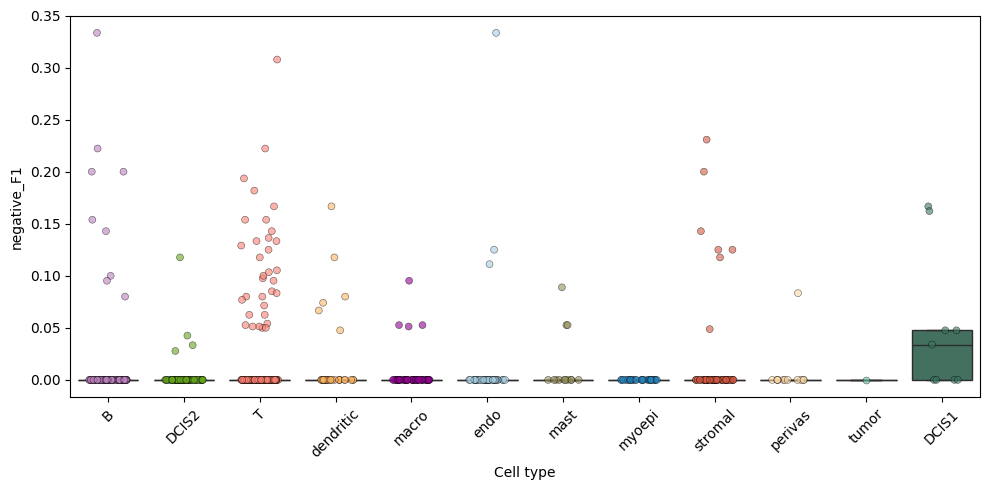

In [14]:
boxplot_per_celltype(st.sdata, feature="negative_F1", palette=col_celltype)

This can also be visualized spatially. The `negative_F1` score is only computed for cells which have a neigbhor of a different type. This clearly shows the DCIS1 cells with high `negative_F1` score, i.e. contamination.

/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:872: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


WARNING  Found 167 NaN values in color data. These observations will be colored with the 'na_color'.               


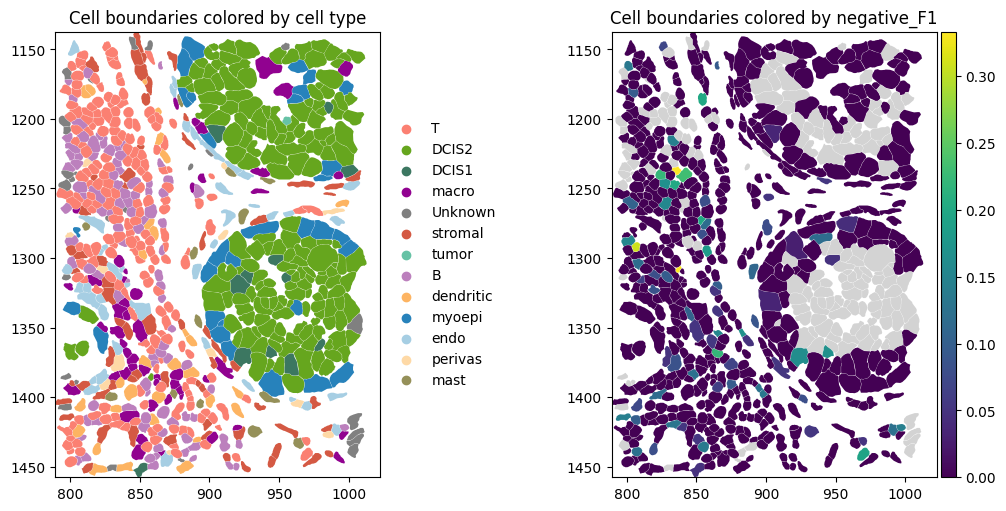

In [15]:
axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)[1].flatten()

st.sdata.pl.render_shapes(
    "cell_boundaries",
    color="transferred_cell_type_plot",
    palette=cols,
    groups=labels,
    outline_color="white",
    outline_width=0.5,
).pl.show(ax=axes[0], title="Cell boundaries colored by cell type", coordinate_systems="global")

st.sdata.pl.render_shapes(
    "cell_boundaries",
    color="negative_F1",
    outline_color="white",
    outline_width=0.5,
).pl.show(ax=axes[1], title="Cell boundaries colored by negative_F1", coordinate_systems="global")

##### `positive_F1`

Cells annotated as mast and DCIS2 show the highest `positive_F1` scores, suggesting that their cell identity is captured most consistently by positive markers. 

/tmp/ipykernel_4091032/2467939028.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(celltype_col)[feature]


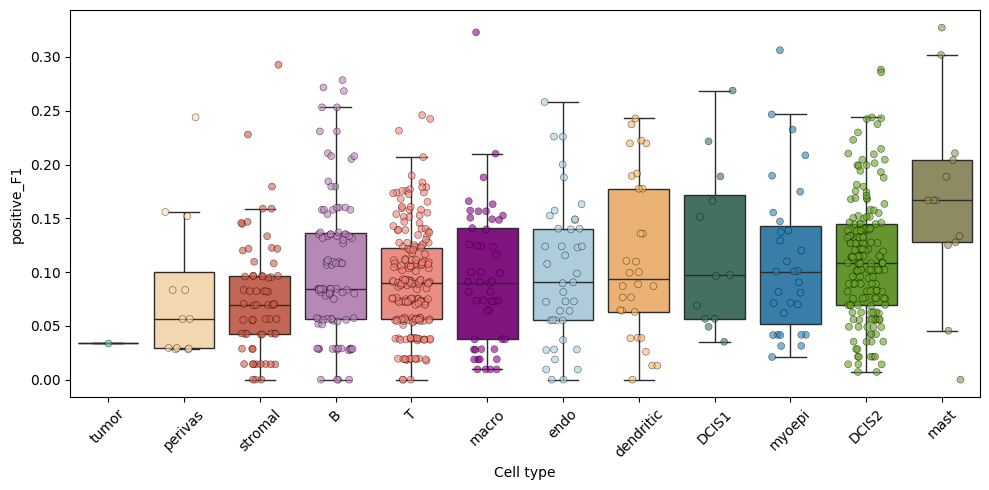

In [16]:
boxplot_per_celltype(st.sdata, feature="positive_F1", palette=col_celltype)

The `positive_F1`score is computed globally, i.e. irrespective of the cell neighborhood, so there are fewer missing values than for `negative_F1`. The spatial plot below is in line with the boxplot above, showing that cells of type DCIS2 and mast show the highest `positive_F1`.

/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:872: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


WARNING  Found 26 NaN values in color data. These observations will be colored with the 'na_color'.                


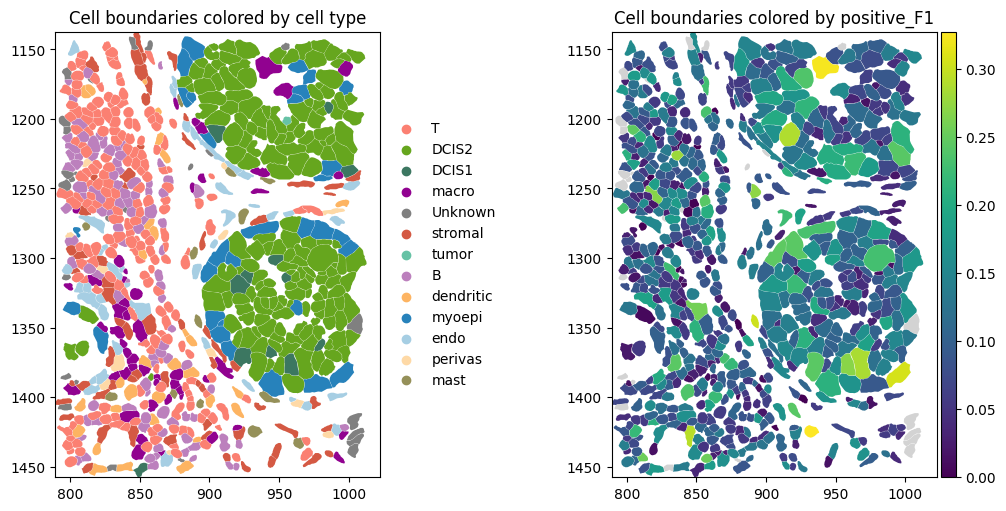

In [17]:
axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)[1].flatten()

st.sdata.pl.render_shapes(
    "cell_boundaries",
    color="transferred_cell_type_plot",
    palette=cols,
    groups=labels,
    outline_color="white",
    outline_width=0.5,
).pl.show(ax=axes[0], title="Cell boundaries colored by cell type", coordinate_systems="global")

st.sdata.pl.render_shapes(
    "cell_boundaries",
    color="positive_F1",
    outline_color="white",
    outline_width=0.5,
).pl.show(ax=axes[1], title="Cell boundaries colored by positive_F1", coordinate_systems="global")

##### `F1_purity`

Cells of type **DCIS1** (which have high transcript counts) show the highest `negative_F1` and the fourth-highest `positive_F1`. This is expected: cells with higher transcript counts tend to capture more positive markers, but also have a higher risk of capturing negative markers. As a result, the combined metric `F1_purity`, which balances `positive_F1` and `negative_F1`, provides a more representative measure of purity. Accordingly, **DCIS1** ranks among the cell types with the lowest purity, while **DCIS2** and **mast** cells show the highest purity.

/tmp/ipykernel_4091032/2467939028.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(celltype_col)[feature]


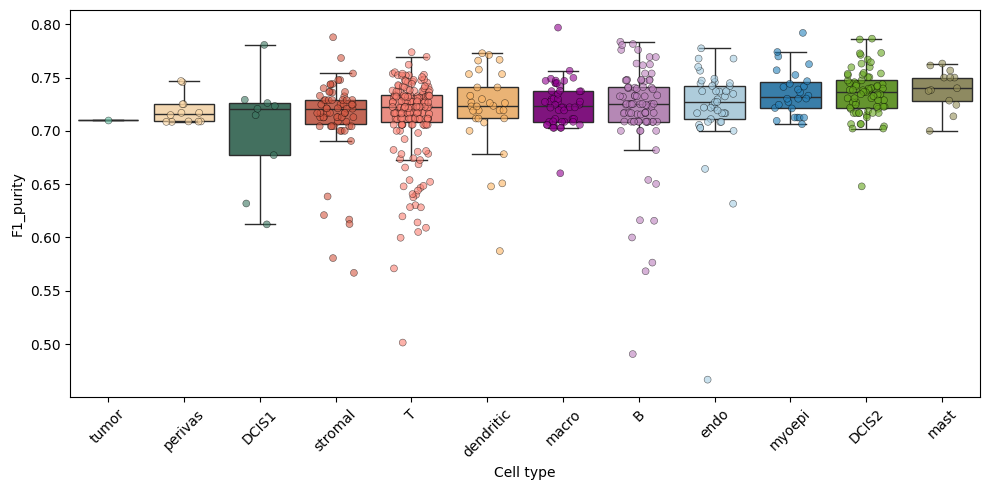

In [18]:
boxplot_per_celltype(st.sdata, feature="F1_purity", palette=col_celltype)

#### Neighborhood contamination

Marker purity summarizes how well a cell matches its own markers and avoids neighborhood-relevant negatives. In many cases, we also want to quantify (i) **how many contaminating transcripts** are present per cell and (ii) **which neighboring cell types** contribute to this signal. We therefore compute neighborhood contamination.

We treat a gene as contamination-relevant for a target cell type `c_tgt` if it is (i) a **negative marker of `c_tgt`**, (ii) simultaneously a **positive marker of a neighboring source type `c_src`**, and (iii) actually **expressed (>0) in at least one of the neighboring cells of the source type** (`require_neighbor_expression` , default=True).

This yields two levels of output:

**Per-cell metrics.**
For each cell, we compute
- `neg_marker_contam_counts`: the total number of transcripts for contamination-relevant genes, and
- `neg_marker_contam_fraction`: a gene-wise average of  
  `x_i(g) / (x_i(g) + mean_neighbor(g))`,  
  which measures how much of the shared marker signal is assigned to the focal cell rather than to its neighborhood.

**Directed cell-type contamination (stored in `.uns`):**
By aggregating across cells, we construct
- `uns_key`: a directed **source → target** matrix where each entry is the average strength of contamination from one cell type into another, and
- `uns_key_binary`: a complementary directed matrix that reports what percentage of cells of a target type is contaminated by each source type.

If no neighborhood graph is present (`neighbors_key not in sdata.tables[tables_key].obsp`), it is automatically computed from cell centroids using a Delaunay graph.

In [19]:
per_cell_df, cont_mat, cont_bin = st.sp.calculate_neighbor_contamination(
    cell_type_key="transferred_cell_type",
    markers=markers,
    require_neighbor_expression=True,
    neighbors_key="spatial_connectivities",
    uns_key="negative_marker_contamination",
    uns_key_binary="negative_marker_contamination_binary",
    inplace=True,
)

##### `neg_marker_contam_counts`

The spatial plot below shows, for each target cell, the number of contaminating transcripts. If desired, this quantity can be normalized by the total number of transcripts per cell. As expected, the plot correlates with the `negative_F1`score from above.

/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:872: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


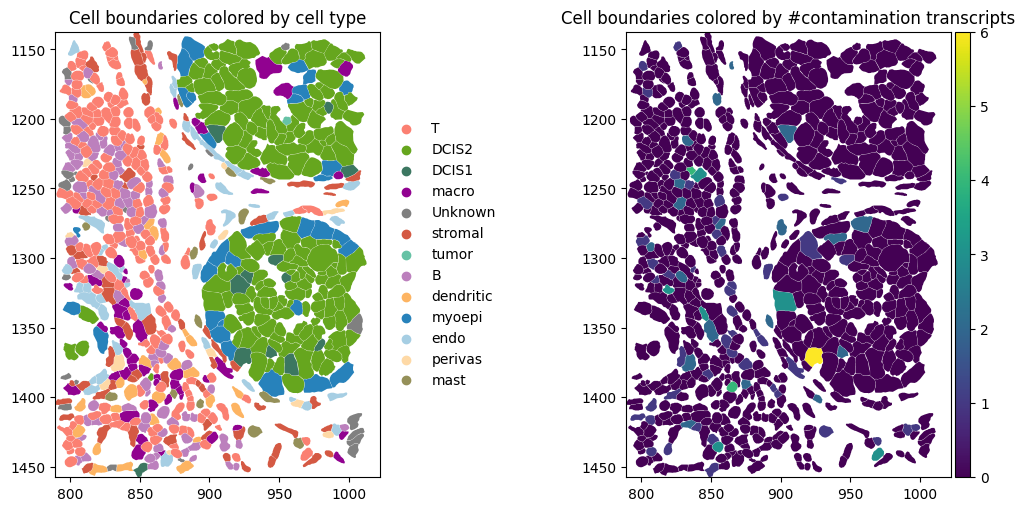

In [20]:
axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)[1].flatten()

st.sdata.pl.render_shapes(
    "cell_boundaries",
    color="transferred_cell_type_plot",
    palette=cols,
    groups=labels,
    outline_color="white",
    outline_width=0.5,
).pl.show(ax=axes[0], title="Cell boundaries colored by cell type", coordinate_systems="global")

st.sdata.pl.render_shapes(
    "cell_boundaries",
    color="neg_marker_contam_counts",
    outline_color="white",
    outline_width=0.5,
).pl.show(ax=axes[1], title="Cell boundaries colored by #contamination transcripts", coordinate_systems="global")

##### `neg_marker_contam_fraction`

In addition, we can plot `neg_marker_contam_fraction`, the fraction of the signal that is "living" in the wrong cell instead of in the neighbors. 

Relevant only if `require_neighbor_expression` = `False`: `neg_marker_contam_fraction`=1 means that 100% of the signal lives in the wrong cell. 

/home/lazic/.venvs/segtraq_py311/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:872: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


WARNING  Found 668 NaN values in color data. These observations will be colored with the 'na_color'.               


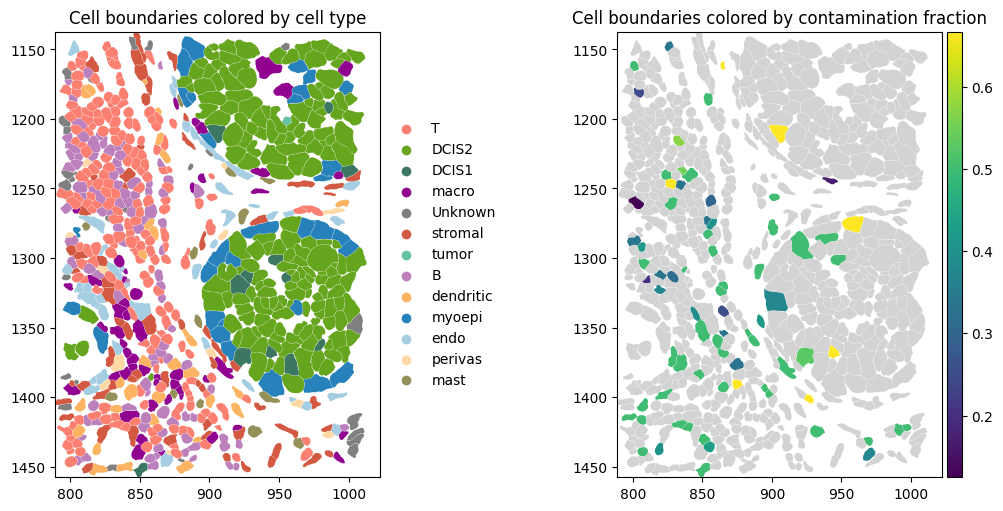

In [21]:
axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)[1].flatten()

st.sdata.pl.render_shapes(
    "cell_boundaries",
    color="transferred_cell_type_plot",
    palette=cols,
    groups=labels,
    outline_color="white",
    outline_width=0.5,
).pl.show(ax=axes[0], title="Cell boundaries colored by cell type", coordinate_systems="global")

st.sdata.pl.render_shapes(
    "cell_boundaries",
    color="neg_marker_contam_fraction",
    outline_color="white",
    outline_width=0.5,
).pl.show(ax=axes[1], title="Cell boundaries colored by contamination fraction", coordinate_systems="global")

##### `.uns["negative_marker_contamination_binary"]`

The heatmap below shows, for each source–target cell-type pair, the **fraction of all target cells** contaminated by transcripts from a neighboring source cell type.

Percentages within a column may sum to more than 100% because a single target cell can be contaminated by **multiple** neighboring source cell types and is therefore counted for each of them.

DCIS1 cells are mostly contaminated by DCIS2 cells, which makes sense since they are frequent neighbors. T cells are contaminated by stromal and B cells.

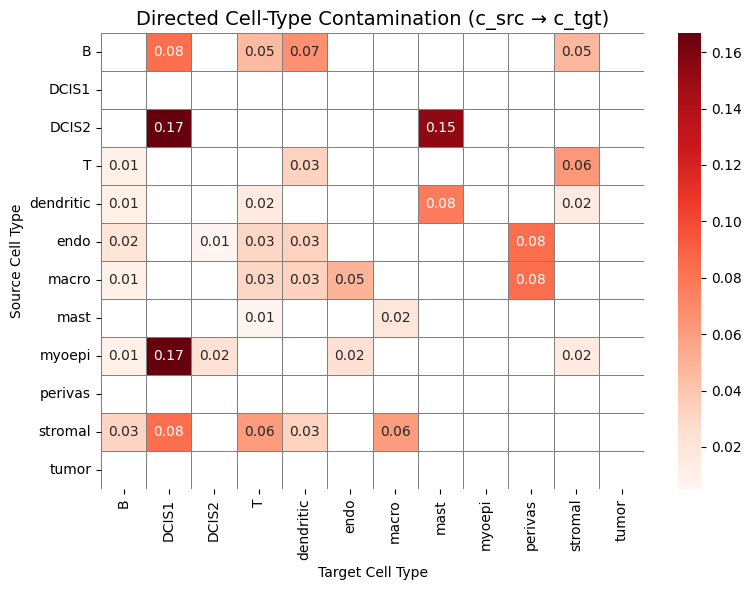

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cont_bin,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    linewidths=0.5,
    linecolor="gray",  # or "viridis", "magma", "rocket"
)
plt.title("Directed Cell-Type Contamination (c_src → c_tgt)", fontsize=14)
plt.xlabel("Target Cell Type")
plt.ylabel("Source Cell Type")
plt.tight_layout()
plt.show()

##### `.uns["negative_marker_contamination"]`

The heatmap below reports, for each source–target cell-type pair, the **mean contamination fraction** aggregated across all contributing cells and genes.  
Each entry corresponds to the average value of fraction of the signal that is "living" in the wrong cell (source cell) instead of in the neighbors (target cell).

Relevant only if `require_neighbor_expression` = `False`: Values close to **1** indicate cases where the target cell carries most or all of the detected signal for a given gene, while neighboring source cells show little or no expression of that gene. This typically reflects rare or low-count events, such as single-transcript misassignments.


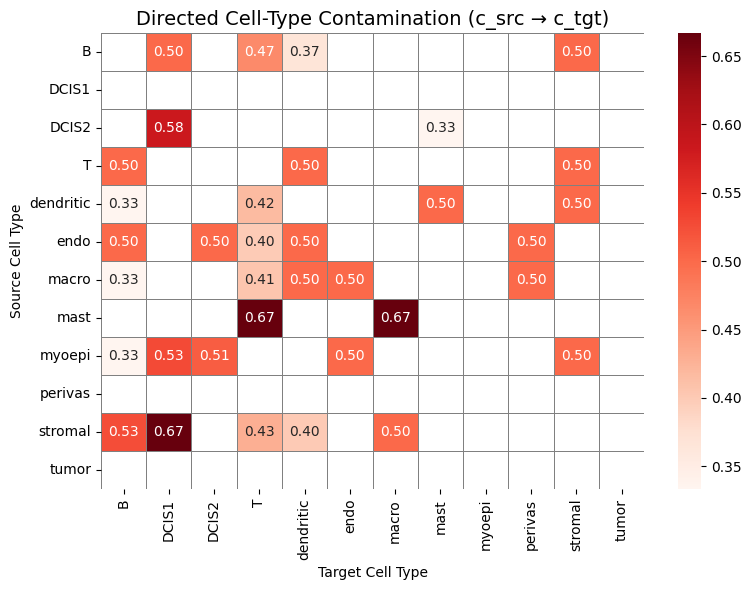

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cont_mat,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    linewidths=0.5,
    linecolor="gray",  # or "viridis", "magma", "rocket"
)
plt.title("Directed Cell-Type Contamination (c_src → c_tgt)", fontsize=14)
plt.xlabel("Target Cell Type")
plt.ylabel("Source Cell Type")
plt.tight_layout()
plt.show()

#### Compute mutually exclusive co-expression rate (MECR)

The `compute_MECR` function assesses mutual exclusivity between marker genes using Fisher’s exact test on binary gene detection (expression `> 0`). Candidate pairs are constructed as unique, unordered combinations of positive and negative markers across cell types, excluding gene pairs that co-occur as positive markers in any cell type. Fisher’s exact test with `alternative="less"` is used to test whether genes co-occur less often than expected under independence, while odds ratios are reported with a pseudocount correction to avoid infinities in sparse data. By conditioning on the marginal detection frequencies of each gene, Fisher’s exact test does not favor methods with low overall transcript counts.

In [25]:
mecr = st.sp.compute_MECR(
    markers=markers,
    pseudocount=0.5,
    inplace=True,
)

/tmp/ipykernel_4091032/2897950232.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/tmp/ipykernel_4091032/2897950232.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels)


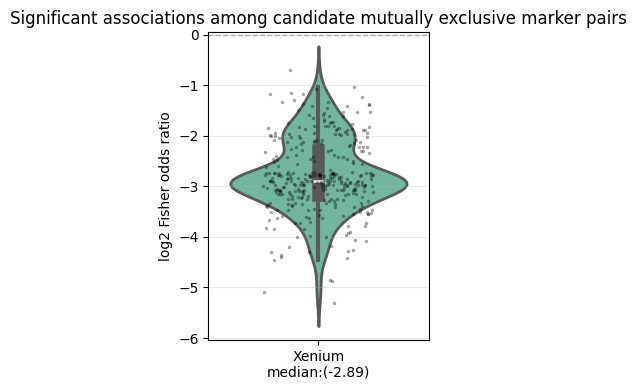

In [29]:
rows = []
tbl = st.sdata.tables["table"]
fisher_or = tbl.uns.get("Fisher_OR", {})
fisher_p = tbl.uns.get("Fisher_pval", {})

for k, score in fisher_or.items():
    if score is None or not np.isfinite(score):
        continue

    pval = fisher_p.get(k, np.nan)
    if not np.isfinite(pval) or pval >= 0.05:
        continue  # keep only significant results

    rows.append(
        {
            "method": "Xenium",
            "Fisher_OR": np.log2(score),
        }
    )

df = pd.DataFrame(rows)

median_order = df.groupby("method")["Fisher_OR"].median().sort_values().index.tolist()

# Compute medians in plotting order
medians = df.groupby("method")["Fisher_OR"].median().reindex(median_order)

# Build x-axis labels with medians
xtick_labels = [f"{m}\nmedian:({medians[m]:.2f})" for m in median_order]

plt.figure(figsize=(3, 4))

# --- Violin plot ---
ax = sns.violinplot(
    data=df,
    x="method",
    y="Fisher_OR",
    order=median_order,
    palette="Set2",
    linewidth=2,
)

# --- Stripplot overlay ---
sns.stripplot(
    data=df,
    x="method",
    y="Fisher_OR",
    order=median_order,
    color="black",
    size=2.5,
    alpha=0.35,
    jitter=0.25,
    ax=ax,
)

# Reference line: OR = 1
ax.axhline(0, ls="--", lw=1, color="gray", alpha=0.6)

# Apply new x-axis labels
ax.set_xticklabels(xtick_labels)

ax.set_ylabel("log2 Fisher odds ratio")
ax.set_xlabel("")
ax.set_title("Significant associations among candidate mutually exclusive marker pairs")

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()